In [1]:
from stable_baselines3 import PPO

In [2]:
model = PPO.load('./ppo_data/best_model.zip')

In [3]:
model.policy

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (shared_net): Sequential()
    (policy_net): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=1, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)

In [4]:
mlp_extractor_state_dict = model.policy.mlp_extractor.policy_net.state_dict()
action_net = model.policy.action_net.state_dict()

In [5]:
import torch
import torch.nn as nn
# from torch.nn.functional import one_hot, log_softmax, softmax, normalize

class Agent(nn.Module):

    '''
    This class defines a neural network as an agent. 
    The agent takes in observation and returns an action.
    '''

    def __init__(self, observation_space_size: int, action_space_size: int, hidden_size: int):
        super(Agent, self).__init__()

        torch.manual_seed(0)
        
        self.layer_1 = nn.Linear(in_features=observation_space_size, out_features=hidden_size, bias=True)
        self.layer_2 = nn.Linear(in_features=hidden_size, out_features=hidden_size, bias=True)
        self.layer_3 = nn.Linear(in_features=hidden_size, out_features=action_space_size, bias=True)
        self.activation_function = nn.Tanh()

    def forward(self, x):
        
        x = self.activation_function(self.layer_1(x))
        x = self.activation_function(self.layer_2(x))
        x = self.layer_3(x)
        
        return x 

In [6]:
leanred_policy = Agent(observation_space_size = 6,
                      action_space_size = 1,
                      hidden_size = 64)

In [7]:
with torch.no_grad():
    leanred_policy.layer_1.weight.copy_(mlp_extractor_state_dict['0.weight'])
    leanred_policy.layer_1.bias.copy_(mlp_extractor_state_dict['0.bias'])
    leanred_policy.layer_2.weight.copy_(mlp_extractor_state_dict['2.weight'])
    leanred_policy.layer_2.bias.copy_(mlp_extractor_state_dict['2.bias'])
    leanred_policy.layer_3.weight.copy_(action_net['weight'])
    leanred_policy.layer_3.bias.copy_(action_net['bias'])
    
leanred_policy = leanred_policy.to('cpu')

In [8]:
import trading_vix_env

In [9]:
env = trading_vix_env.trading_vix_env()
env.seed(0)

/home/zuhao/anaconda2/envs/p37/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [10]:
trading_action_percentage = []
trading_action_buy_sell = []
portfolio_value = []
stock_price = []

In [11]:
observation = env.reset()

trading_action_percentage.append(0) #start off with 0 in stock
trading_action_buy_sell.append(0) #neigher buy nor sell
portfolio_value.append(env.current_portfolio_value)
stock_price.append(observation[0])

while True:
    observation = torch.tensor(observation, dtype=torch.float)
    action_from_policy = leanred_policy(observation)
    action_from_policy = torch.clamp(action_from_policy,0,1)
    
    observation, reward, done ,info = env.step(action_from_policy.detach().numpy())
    
    #record data from the trajectory
    trading_action_percentage.append(action_from_policy.detach().numpy()[0])
    if info['execute_buy']:
        trading_action_buy_sell.append(1)
    elif info['execute_sell']:
        trading_action_buy_sell.append(-1)
    else:
        trading_action_buy_sell.append(0)
    portfolio_value.append(info['current_portfolio'])
    stock_price.append(observation[0])
    
    if done:
        break

the reward is 75.65505117297373


In [12]:
print(len(trading_action_percentage))
print(len(trading_action_buy_sell))
print(len(portfolio_value))
print(len(stock_price))

202
202
202
202


In [13]:
import matplotlib.pyplot as plt
import numpy as np

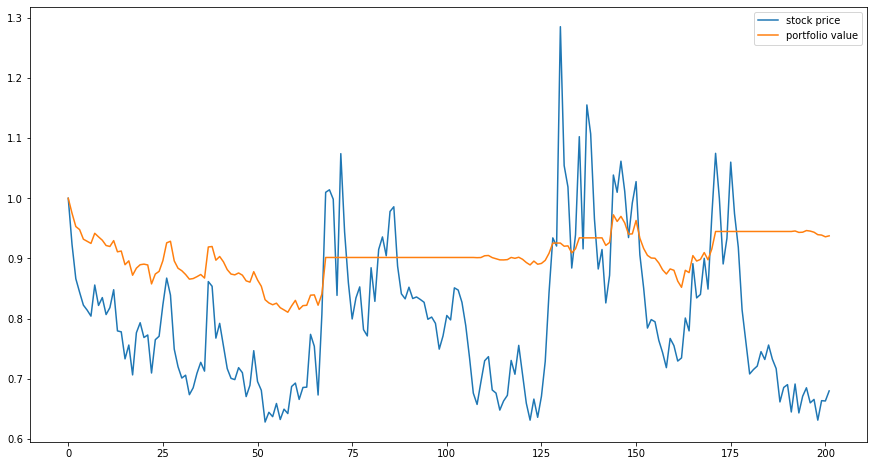

In [14]:
plt.rcParams["figure.figsize"] = (15,8)

plt.plot(np.asarray(stock_price)/stock_price[0],label = 'stock price')
plt.plot(np.asarray(portfolio_value)/portfolio_value[0],label = 'portfolio value')
plt.legend()
plt.show()

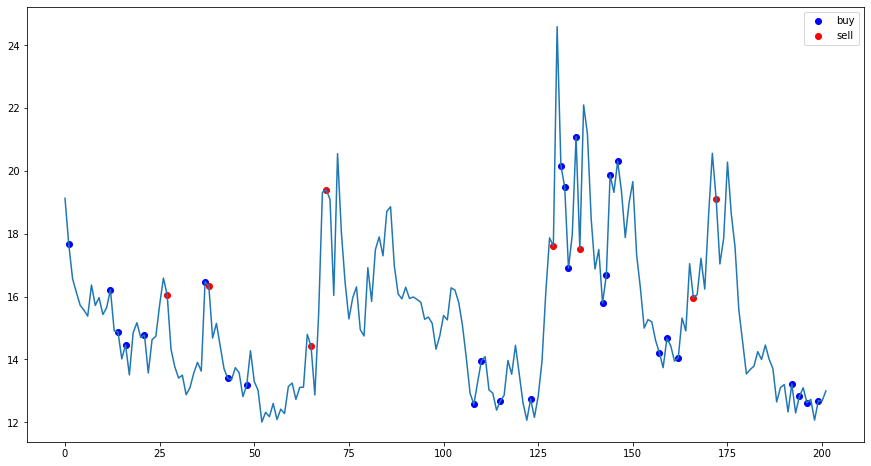

In [15]:


already_plotted_sell_legend = False
already_plotted_buy_legend = False

plt.plot(stock_price)
for time_index in range(0,len(trading_action_buy_sell)):

    if trading_action_buy_sell[time_index]==1:
        #print('the buy price is',price_history[time_index])
        if already_plotted_buy_legend == False:
            plt.scatter(time_index,stock_price[time_index],color = 'b',label = 'buy')
            already_plotted_buy_legend = True
        else:
            plt.scatter(time_index,stock_price[time_index],color = 'b')

    elif trading_action_buy_sell[time_index]==-1:
        #print('the sell price is',price_history[time_index])
        #print(' ')
        if already_plotted_sell_legend == False:
            plt.scatter(time_index,stock_price[time_index],color = 'r',label = 'sell')
            already_plotted_sell_legend = True
        else:
            plt.scatter(time_index,stock_price[time_index],color = 'r')
plt.legend()
plt.show()



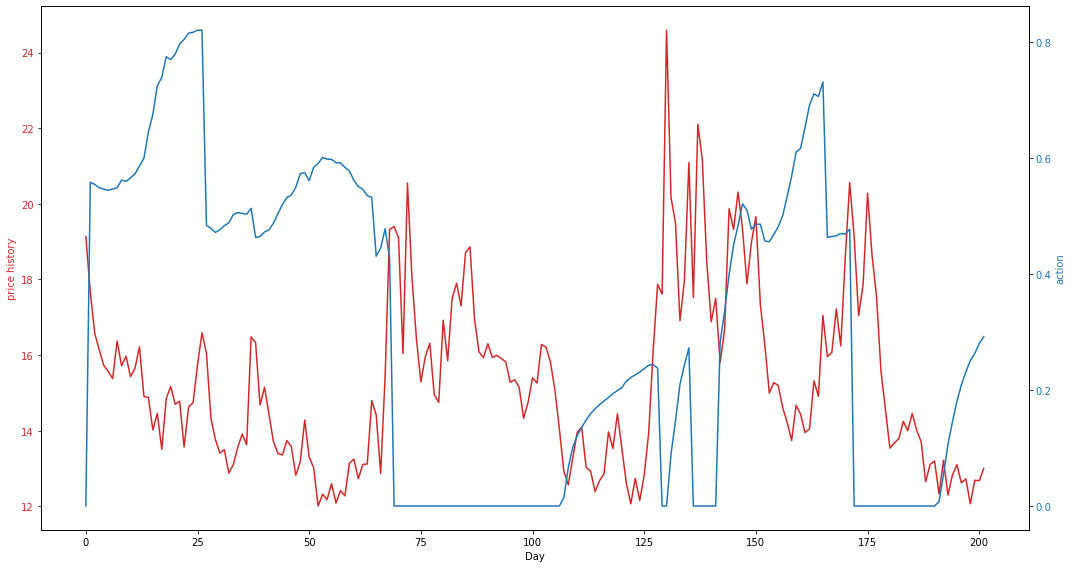

In [16]:
plt.rcParams["figure.figsize"] = (15,8)

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Day')
ax1.set_ylabel('price history', color=color)
ax1.plot(stock_price, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('action', color=color)  # we already handled the x-label with ax1
ax2.plot(trading_action_percentage, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [17]:
#call the evaluate policy from stablebale lines

env = trading_vix_env.trading_vix_env()
env.seed(0)

from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=1, deterministic=True)

/home/zuhao/anaconda2/envs/p37/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/zuhao/anaconda2/envs/p37/lib/python3.7/site-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


the reward is 75.65505418221885


In [18]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=50, deterministic=True)

the reward is 29.857728827869664
the reward is 25.831916150397248
the reward is 13.408317210961059
the reward is 21.845903478871264
the reward is 186.14806476008158
the reward is 6.746091394584326
the reward is -2.1083780512017825
the reward is 9.527855004820807
the reward is 3.42243128203053
the reward is 24.482800673230017
the reward is 16.745462958697274
the reward is -6.709635613125755
the reward is 122.15611061831203
the reward is 1.8147175996892315
the reward is 3.306223888959096
the reward is -2.8258046797267298
the reward is 199.56883220086698
the reward is 7.978788009348932
the reward is 70.99965344752722
the reward is 34.962608270416155
the reward is 107.94242900592003
the reward is 116.75228047591594
the reward is 7.23258755711386
the reward is 42.65918035018015
the reward is 23.896401326775333
the reward is 185.33154741069808
the reward is 42.72072067693668
the reward is 50.15612008402451
the reward is 18.07771369552745
the reward is 65.63100430099314
the reward is 16.90373

In [19]:
print('the mean reward is',mean_reward)
print('the std reward is',std_reward)

the mean reward is 49.98970677323639
the std reward is 59.21370494213223
